<a href="https://colab.research.google.com/github/cs-pub-ro/ML/blob/master/homework/hw1/Tema_1_Skel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tema 1 - A taste for music
## Găsirea genului pentru piese

## 1. Scopul Proiectului


Proiectul are ca scop folosirea metode de clasificare pentru a **determina genul muzical** al unor sample-uri audio dintr-un set de date.

Se dorește înțelegerea procedurii tipice de **prelucrare a unui set de date**, de **explorare a atributelor**, precum și efectuarea unei **analize comparative** a mai multor algoritmi de clasificare, evidențiând diferențele între ei prin metrici precum *acuratețe, precizie, regăsire (eng. recall)*. 

## 2. Set de date

Setul de date utilizat poartă denumirea de Free Music Archive [[1]](#fma). 

Dataset-ul utilizat este "usor" modificat - va conține doar 4 genuri muzicale: *Rock*, *Hip-Hop*, *Folk* și *Electronic*.

Setul de date este deja echilibrat (eng. balanced) -- sunt câte 500 de piese din fiecare gen în setul de train și câte 100 în cel de testare.

Dacă setați parametrul [DOWNLOAD_SAMPLE_DATASET](#scrollTo=te02bqsfMhls) se va descărca și un audio sample pentru fiecare track_id atunci când se rulează celula specifică pentru secțiunea [Descărcare](#scrollTo=RxCYjmzTM82o).

Puteți asculta sample-ul din piesă [aici](#scrollTo=te02bqsfMhls).

Se va folosi drept **clasă** (eticheta care trebuie prezisa) *genul muzical cel mai general* (numele coloanei în engleza este *top_genre*) pentru fiecare piesă.


Setul de date conține pentru fiecare sample mai multe atribute (eng. features), de tip numeric, care pot fi folosite pentru clasificare. Acestea pot fi găsite în fișierele *features.csv* sau *echonest.csv*.


Pentru mai multe informații privind setul de date, se poate consulta [acest repository](https://github.com/mdeff/fma).

Dataset-ul utilizat este o copie ușor modificată a celor [3 dataset-uri](https://github.com/mdeff/fma#Data): *fma_small.zip*, *fma_medium.zip*, *fma_large.zip*.

## 3. Workspace Setup

### Parametrii

In [1]:
# Music samples -- has ~ 2GB
DOWNLOAD_SAMPLE_DATASET = False  #@param {type: "boolean"}

### Dependențe

In [2]:
!pip install pandas
!pip install xgboost
!pip install scikit-learn

if DOWNLOAD_SAMPLE_DATASET:
    !pip install ffmpeg
    !pip install librosa
    !pip install tqdm

### Import biblioteci

In [3]:
if DOWNLOAD_SAMPLE_DATASET:
    from tqdm import tqdm
    import librosa

import pandas as pd
from zipfile import ZipFile

import IPython.display as ipd

### Funcții ajutătoare

In [4]:
def _reporthook(t):
    """ ``reporthook`` to use with ``urllib.request`` that prints the process of the download.

    Uses ``tqdm`` for progress bar.

    **Reference:**
    https://github.com/tqdm/tqdm

    Args:
        t (tqdm.tqdm) Progress bar.
    """
    last_b = [0]

    def inner(b=1, bsize=1, tsize=None):
        """
        Args:
            b (int, optional): Number of blocks just transferred [default: 1].
            bsize (int, optional): Size of each block (in tqdm units) [default: 1].
            tsize (int, optional): Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return inner

def getHomeworkArchives():
    """ Checks if the homework dataset is present in the local directory, if not,
    downloads it.
    """
    from os import path

    dataset_info = {
        "fma_song_info.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_info.zip",
        "fma_song_samples.zip": "http://swarm.cs.pub.ro/~gmuraru/ML/HW1/data/fma_song_samples.zip" # Need to upload this
    }

    for dataset_file, dataset_url in dataset_info.items():
        if not path.isfile(dataset_file):
            import urllib
            with tqdm(unit='B', unit_scale=True, miniters=1, desc=dataset_file) as t:
                urllib.request.urlretrieve(dataset_url, filename=dataset_file, reporthook=_reporthook(t))

            assert(path.isfile(dataset_file))

            with ZipFile(dataset_file, 'r') as zip_ref:
                zip_ref.extractall()
        else:
            print(f"{dataset_file} already in the local directory")


# ALL THE FUCTIONS FROM THIS POINT FORWARD ARE NEEDED ONLY IF
# DOWNLOAD_SAMPLE_DATASET IS TRUE
def load_tracks():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/tracks.csv"), index_col=0, header=[0,1])


def load_features():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open('song_info/features.csv'), index_col=0, header=[0,1,2])


def load_echonest():
    zipFile = ZipFile("fma_song_info.zip")
    return pd.read_csv(zipFile.open("song_info/echonest.csv"), index_col=0, header=[0,1,2])


def get_song_path(track_id: int):
    ''' Given a track id return the path to the sample

    Args:
        track_id (int): the id for a song found the dataset

    Returns:
        The path to the sample relative to the current directory
    '''

    return f'song_samples/{track_id:06}.mp3'

### Descărcare

In [5]:
getHomeworkArchives()

fma_song_info.zip already in the local directory
fma_song_samples.zip already in the local directory


### Încărcare date

In [6]:
# Load Echonest features for our dataset
echonest = load_echonest()
tracks = load_tracks()
features = load_features()

# True/False masks for selecting training/test
train = tracks['set', 'split'] == 'training'
test = tracks['set', 'split'].isin(['test', 'validation'])

# Get X and Y
X_train = echonest.loc[train, ('echonest', 'audio_features')]
X_test = echonest.loc[test, ('echonest', 'audio_features')]

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

## 4. Problemă de rezolvat



Împărțim problema de rezolvat în două subpuncte principale:
  * Implementarea unui clasificator al genului muzical (eng. genre) pentru un anumit sample de piesă prin intermediul a patru algoritmi (KMeans, Decision Trees/Random Forest, XGBoost și SVM). Construirea unei variante de baza (eng. baseline) a clasificatorului pentru fiecare algoritm propus.
  * Explorarea metodelor prin care pot fi îmbunătățite rezultatele fiecarui algoritm în parte (e.g. varierea atributelor, prelucrarea suplimentară a atributelor, modificarea hiperparametrilor algoritmului), evaluarea comparativă intra- (i.e. față de baseline pentru același tip de algoritm) și inter-algoritm.

### 4.1. Implementare si rulare clasificatori

Pentru acest pas se vor rula mai mulți algoritmi pe setul de date și vor fi notate rezultatele obținute.

Veți crea câte un clasificator folosind fiecare din cei patru algoritmi din următoarea listă:
  * KMeans
  * Arbori de decizie, păduri aleatoare
  * XGBoost
  * SVM 

**Observație 1:** Pentru KMeans, fiind **nesupervizat**, vom presupune că *nu* se știe că numărul de clustere este 4.


#### **Utilizarea setului de date**
În general, majoritatea seturilor de date sunt împărțite în:
* setul de antrenare (eng. training dataset) - se rulează algoritmul de învățare pe acest set (eng. fit the model)
* setul de validare (eng. validation dataset sau dev set) - se utilizează pentru modificarea hiperparametrilor algoritmului (eng. tunning the hyperparameters)
* setul de testare (eng. testing dataset sau holdout dataset) - se rulează pentru testarea finală a algoritmului.

Testul de validare și de testare sunt concatenate.

#### **Implementare algoritmi**
Se vor dezvolta clasificatorii *baseline* pe baza fiecărui algoritm din cei listați mai sus. 
Se vor utiliza implementările default din bibliotecile alese pentru a obține baseline-ul.
Folosiți drept features *audio_features* din tabela de *echonest* (sunt deja selectate în schelet).

Se vor folosi set-ul *train* pentru antrenare și *test* pentru testare.

#### **Evaluare** [1 pct]
Se găsește [aici](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) o listă cu metrici folosite, in general, pentru evaluarea algoritmilor de machine learning.

Pentru fiecare algoritm în parte, se vor raporta metricile de *accuracy*, *precision*, *recall*, *f-score* și *matricea de confuzie (eng. confusion matrix)*.

**Observații KMeans**
1. Având în vedere că KMeans nu este un algoritm supervizat, putem să combinăm cele 2 seturi de date (train + testare) pentru a face clusterizarea.
2. Facem rescale *feature-urilor* astfel încât acestea să fie centrate în 0 cu o deviație standard de 1 - [standardizarea datelor](#scrollTo=-tkdMwB5S-as)
3. Rulam KMeans pe setul de antrenare utilizând un număr diferit de clustere (eg. 2, 3, 4, 5, 6).
4. Verificam utlizând metoda [silhouette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) care este numărul optim de clustere (puteți încerca și cu [elbow](https://www.oreilly.com/library/view/statistics-for-machine/9781788295758/c71ea970-0f3c-4973-8d3a-b09a7a6553c1.xhtml) însă va trebui să creștem lungmea intervalului de clustere).
5. Alegem numărul optim de clustere și calculam **doar** *randIndex*.
6. [Opțional] Vom analiza coordonatele centroizilor pentru a observa cum diferă genurile muzicale în funcție de *audio_features*. 
6. [Opțional] Vom testa să vedeți că piesele din același cluster seamănă utilizând codul de [aici](#scrollTo=fS6s1c-gPyMN).

**Observații DecisionTree/RandomForest**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) din biblioteca scikit-learn. 

**Observații XGBoost**

Implementarea sugerată este cea din biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**Observații SVM**

Implementarea sugerată este [cea](https://scikit-learn.org/stable/modules/svm.html) din biblioteca scikit-learn.

#### Importuri

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from statistics import mean, stdev
import matplotlib.pyplot as plt

#### Functii ajutatoare

In [8]:
classes = Y_test.unique()

def evaluate_metrics(Y_test, Y_pred):
    return {
        "accuracy": accuracy_score(Y_test, Y_pred),
        "precision": precision_score(Y_test, Y_pred, average=None),
        "recall": recall_score(Y_test, Y_pred, average=None),
        "f1": f1_score(Y_test, Y_pred, average=None),
        "confusion_matrix": confusion_matrix(Y_test, Y_pred)
    }
    

def print_metrics(metrics):
    print('accuracy score is:', metrics["accuracy"])
    print()

    print('precision scores are:')
    for i in range(len(classes)):
        print('\tclass', classes[i], metrics["precision"][i])
    print()

    print('recall scores are:')
    recalls = recall_score(Y_test, Y_pred, average=None)
    for i in range(len(classes)):
        print('\tclass', classes[i], metrics["recall"][i])
    print()

    print('f1 scores are')
    f1s = f1_score(Y_test, Y_pred, average=None)
    for i in range(len(classes)):
        print('\tclass', classes[i], metrics["f1"][i])
    print()

    print('confusion matrix is:')
    print(metrics["confusion_matrix"])
    print()

    
def randIndex(clusters, labels):
    K, = clusters.shape
    TP = FP = FN = TN = 0

    for i in range(K):
        for j in range(K):
            if clusters[i] == clusters[j] and labels[i] == labels[j]:
                TP = TP + 1
            if clusters[i] == clusters[j] and labels[i] != labels[j]:
                FP = FP + 1
            if clusters[i] != clusters[j] and labels[i] == labels[j]:
                FN = FN + 1
            if clusters[i] != clusters[j] and labels[i] != labels[j]:
                TN = TN + 1

    return (TP + TN) / (TP + FP + FN + TN)

#### KMeans

In [9]:
X = pd.concat([X_train, X_test])
Y = pd.concat([Y_train, Y_test])

X = StandardScaler().fit_transform(X)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

# Am obtinut silhouette_score cel mai mare pentru 4 clustere si calculam randIndex

clusterer = KMeans(n_clusters=4)
cluster_labels = clusterer.fit_predict(X)

print('randIndex:', randIndex(cluster_labels, Y.to_list()))

For n_clusters = 2 The average silhouette_score is : 0.17270504642031057
For n_clusters = 3 The average silhouette_score is : 0.1723567117081337
For n_clusters = 4 The average silhouette_score is : 0.1870034330635089
For n_clusters = 5 The average silhouette_score is : 0.17963010031407475
For n_clusters = 6 The average silhouette_score is : 0.18022469244568756
randIndex: 0.6771663194444445


#### Random Forest

In [10]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

print_metrics(evaluate_metrics(Y_test, Y_pred))

accuracy score is: 0.745

precision scores are:
	class Rock 0.7159090909090909
	class Hip-Hop 0.7767857142857143
	class Folk 0.7714285714285715
	class Electronic 0.7052631578947368

recall scores are:
	class Rock 0.63
	class Hip-Hop 0.87
	class Folk 0.81
	class Electronic 0.67

f1 scores are
	class Rock 0.6702127659574468
	class Hip-Hop 0.820754716981132
	class Folk 0.7902439024390244
	class Electronic 0.6871794871794872

confusion matrix is:
[[63 10 16 11]
 [ 0 87  0 13]
 [14  1 81  4]
 [11 14  8 67]]



#### XGBoost

In [11]:
# XGBoost cere datele ca numere asa ca le codificam
le = LabelEncoder()
Y = le.fit_transform(Y_train)

clf = XGBClassifier(n_estimators = 100)
clf.fit(X_train, Y)

Y_pred = le.inverse_transform(clf.predict(X_test))

print_metrics(evaluate_metrics(Y_test, Y_pred))

accuracy score is: 0.7225

precision scores are:
	class Rock 0.6808510638297872
	class Hip-Hop 0.7142857142857143
	class Folk 0.7941176470588235
	class Electronic 0.6956521739130435

recall scores are:
	class Rock 0.64
	class Hip-Hop 0.8
	class Folk 0.81
	class Electronic 0.64

f1 scores are
	class Rock 0.6597938144329897
	class Hip-Hop 0.7547169811320756
	class Folk 0.801980198019802
	class Electronic 0.6666666666666666

confusion matrix is:
[[64 12 13 11]
 [ 5 80  1 14]
 [13  3 81  3]
 [12 17  7 64]]



#### SVM

In [12]:
clf = SVC(gamma='auto', kernel='linear')
clf.fit(X_train, Y)

Y_pred = le.inverse_transform(clf.predict(X_test))

print_metrics(evaluate_metrics(Y_test, Y_pred))

accuracy score is: 0.715

precision scores are:
	class Rock 0.6504854368932039
	class Hip-Hop 0.7413793103448276
	class Folk 0.7741935483870968
	class Electronic 0.6931818181818182

recall scores are:
	class Rock 0.67
	class Hip-Hop 0.86
	class Folk 0.72
	class Electronic 0.61

f1 scores are
	class Rock 0.6600985221674877
	class Hip-Hop 0.7962962962962963
	class Folk 0.7461139896373057
	class Electronic 0.648936170212766

confusion matrix is:
[[67 13 11  9]
 [ 1 86  1 12]
 [18  4 72  6]
 [17 13  9 61]]



### 4.2. Metode de îmbunătățire și evaluare comparativă

Pentru fiecare algoritm, vom explora metode prin care să îmbunătățiți performanțele de la pasul precedent (cel de realizarea a baseline-ului).

**Îmbunătățire algoritmi**

Avem în vedere următoarea listă de idei (și nu numai):
* adăugarea de mai multe feature-uri (momentan la baseline s-au folosit doar *audio_features*)
* [preprocesarea datelor](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing) (eng. data preprocessing)
* [selectarea atributelor](https://scikit-learn.org/stable/modules/feature_selection.html) (eng. feature selection)
* modificarea hiperparametrilor fiecărui algoritm (e.g. tipul de kernel la SVM, coeficienți de regularizare, numărul de arbori în RandomForest, adâncimea arborilor în RandomForest)
    * **Atenție!**, exemplu de **AȘA NU**: rularea cu un număr maxim de 10 iterații la baseline și 100 de iterații la modelul mai bun.

În *fma_song_info.zip* există și un fișier *features.csv* -- detalii despre acesta se găsesc în repository-ul menționat în secțiunea [Set de date](#scrollTo=67UlrcAdqj3N).

**Evaluare îmbunătățiri**

* Evaluam variantele îmbunătățite ale algoritmilor, folosind 5-fold [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/). Folosiți aceleași metrici ca în cazul baseline-ului.  **Atenție!** Pentru cross-validation trebuie să vă refaceti împartirea in train/test a setului de date.
* Realizăm grafice în care să arătăm analiza intra-algoritm a performanței îmbunătățirii (e.g. folosiți un bar chart pentru a compara accuracy-ul variantei baseline a RandomForest cu cea a variantei îmbunătățite).
* Realizăm grafice în care să arătăm analiza inter-algoritm a performanțelor. Vom face câte un grafic per metrică (e.g. accuracy, precision, recall) în care să încludem valorile obținute de fiecare algoritm îmbunătățit în parte. 

#### Impartirea datelor

In [13]:
audio_features_train = echonest.loc[train, ('echonest', 'audio_features')]
audio_features_test = echonest.loc[test, ('echonest', 'audio_features')]

temporal_features_train = echonest.loc[train, ('echonest', 'temporal_features')]
temporal_features_test = echonest.loc[test, ('echonest', 'temporal_features')]

X_train = audio_features_train.join(temporal_features_train)
X_test = audio_features_test.join(temporal_features_test)

Y_train = tracks.loc[train, ('track', 'genre_top')]
Y_test = tracks.loc[test, ('track', 'genre_top')]

X = StandardScaler().fit_transform(pd.concat([X_train, X_test]))
X = pd.DataFrame(X, X[:,0])

Y = pd.concat([Y_train, Y_test])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# codificam Y_train pentru a nu avea probleme cu XGBoost
le = LabelEncoder()
le.fit(Y_train)

Y_train = le.transform(Y_train)

#### Alegere K pentru SelectKBest

In [14]:
baseline_models = [
    RandomForestClassifier(n_estimators=100),
    XGBClassifier(n_estimators = 100),
    SVC(gamma='auto', kernel='linear')
]

k_vals = [10, 25, 50, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 125, 150]

max_mean = 0
max_k = None

for k_val in k_vals:
    model_results = [[], [], []]
    
    for iteration in range(10):
        for index, model in enumerate(baseline_models):
            selector = SelectKBest(k=k_val).fit(X_train, Y_train)
            cols = selector.get_support(indices=True)
            features_train = StandardScaler().fit_transform(X_train.iloc[:,cols])
            features_test = StandardScaler().fit_transform(X_test.iloc[:,cols])

            model.fit(features_train, Y_train)
            
            Y_pred = le.inverse_transform(model.predict(features_test))
            
            model_results[index].append(evaluate_metrics(Y_test, Y_pred)['accuracy'])

    model_means = [mean(results) for results in model_results]

    if mean(model_means) > max_mean:
        max_mean = mean(model_means)
        max_k = k_val
            
print('Best k =', max_k)

Best k = 100


#### Preprocesarea datelor

In [15]:
selector = SelectKBest(k=100).fit(X, Y)
cols = selector.get_support(indices=True)
X_train = X_train.iloc[:,cols]
X_test = X_test.iloc[:,cols]

#### Hiperparametri KMeans

In [16]:
X = np.vstack((X_train, X_test))
Y = np.hstack((Y_train, le.transform(Y_test)))

init_vals = ['k-means++', 'random']
max_iter_vals = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
tol_vals = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

max_rand_index = 0.0
max_value = ()

for init_val in init_vals:
    for max_iter_val in max_iter_vals:
        for tol_val in tol_vals:
            cluster_labels = KMeans(n_clusters=4, init=init_val, max_iter=max_iter_val, tol=tol_val).fit_predict(X)

            rand_index = randIndex(cluster_labels, Y)
            
            if rand_index > max_rand_index:
                max_rand_index = rand_index
                max_value = (init_val, max_iter_val, tol_val)

print(
    'init:', max_value[0],
    'max_iter:', max_value[1],
    'tol:', max_value[2]
)

init: k-means++ max_iter: 700 tol: 0.001


#### Hiperparametri Random Forest

In [17]:
n_estimators_vals = [10, 25, 50, 100, 200, 300, 400, 500]
max_depth_vals = [10, 20, 30, 40, 50, 75, None]
max_features_vals = ['sqrt', 'log2', 0.1, 0.2, 0.3]

max_cv = (0, 1)
max_value = ()

for n_estimators_val in n_estimators_vals:
    for max_depth_val in max_depth_vals:
        for max_features_val in max_features_vals:
            clf = RandomForestClassifier(
                n_estimators=n_estimators_val,
                max_depth=max_depth_val,
                max_features=max_features_val
            )

            cv_score = cross_val_score(clf, X_test, Y_test, cv=5)

            if round(mean(cv_score), 3) == round(max_cv[0], 3) and stdev(cv_score) < max_cv[1]:
                max_cv = (mean(cv_score), stdev(cv_score))
                max_val = (n_estimators_val, max_depth_val, max_features_val)
            elif mean(cv_score) > max_cv[0]:
                max_cv = (mean(cv_score), stdev(cv_score))
                max_val = (n_estimators_val, max_depth_val, max_features_val)

print(
    'n_estimators:', max_val[0],
    'max_depth:', max_val[1],
    'max_features:', max_val[2]
)

n_estimators: 300 max_depth: None max_features: 0.1


#### Hiperparametri XGBoost

In [18]:
n_estimators_vals = [10, 25, 50, 100, 200, 300, 400, 500]
booster_vals = ['gblinear', 'gbtree', 'dart']
learning_rate_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
max_depth_vals = [3, 4, 5, 6, 7, 8, 9, 10]

max_cv = (0, 1)
max_value = ()

for n_estimators_val in n_estimators_vals:
    for booster_val in booster_vals:
        for learning_rate_val in learning_rate_vals:
            for max_depth_val in max_depth_vals:
                clf = XGBClassifier(
                    n_estimators = n_estimators_val,
                    booster=booster_val,
                    learning_rate=learning_rate_val,
                    max_depth=max_depth_val
                )

                cv_score = cross_val_score(clf, X_test, Y_test, cv=5)

                if round(mean(cv_score), 3) == round(max_cv[0], 3) and stdev(cv_score) < max_cv[1]:
                    max_cv = (mean(cv_score), stdev(cv_score))
                    max_val = (n_estimators_val, booster_val, learning_rate_val, max_depth_val)
                elif mean(cv_score) > max_cv[0]:
                    max_cv = (mean(cv_score), stdev(cv_score))
                    max_val = (n_estimators_val, booster_val, learning_rate_val, max_depth_val)

print(
    'n_estimators:', max_val[0],
    'booster:', max_val[1],
    'learning_rate:', max_val[2],
    'max_depth:', max_val[3]
)

n_estimators: 300 booster: gbtree learning_rate: 0.4 max_depth: 10


#### Hiperparametri SVM

In [19]:
kernel_vals = ['linear', 'rbf', 'poly', 'sigmoid']
C_vals = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 100.0, 1000.0]
degree_vals = [2, 3, 4, 5, 6, 7]

max_cv = (0, 1)
max_value = ()

for kernel_val in kernel_vals:
    for C_val in C_vals:
        for degree_val in degree_vals:
            clf = SVC(
                gamma='auto',
                kernel=kernel_val,
                C=C_val,
                degree=degree_val
            )

            cv_score = cross_val_score(clf, X_test, Y_test, cv=5)

            if round(mean(cv_score), 3) == round(max_cv[0], 3) and stdev(cv_score) < max_cv[1]:
                max_cv = (mean(cv_score), stdev(cv_score))
                max_val = (kernel_val, C_val, degree_val)
            elif mean(cv_score) > max_cv[0]:
                max_cv = (mean(cv_score), stdev(cv_score))
                max_val = (kernel_val, C_val, degree_val)

print(
    'kernel:', max_val[0],
    'C:', max_val[1],
    'degree:', max_val[2]
)

kernel: rbf C: 3.0 degree: 2


#### Declarare modele

In [20]:
baseline_kmeans = KMeans(n_clusters=4).fit(X)

tuned_kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=700, tol=0.001).fit(X)

baseline_clfs = [
    RandomForestClassifier(n_estimators=100).fit(X_train, Y_train),
    XGBClassifier(n_estimators = 100).fit(X_train, Y_train),
    SVC(gamma='auto', kernel='linear').fit(X_train, Y_train)
]

tuned_clfs = [
    RandomForestClassifier(n_estimators=300, max_depth=None, max_features=0.1).fit(X_train, Y_train),
    XGBClassifier(n_estimators = 300, booster='gbtree', learning_rate=0.4, max_depth=10).fit(X_train, Y_train),
    SVC(gamma='auto', kernel='rbf', C=3.0).fit(X_train, Y_train)
]

#### Obtinere metrici

In [21]:
cluster_labels_baseline = baseline_kmeans.fit_predict(X)
cluster_labels_tuned = tuned_kmeans.fit_predict(X)

k_means_metrics = (randIndex(cluster_labels_baseline, np.array(Y)), randIndex(cluster_labels_tuned, np.array(Y)))

classifier_metrics = []

for i in range(3):
    Y_pred_baseline = le.inverse_transform(baseline_clfs[i].predict(X_test))
    Y_pred_tuned = le.inverse_transform(tuned_clfs[i].predict(X_test))
    
    classifier_metrics.append((evaluate_metrics(Y_test, Y_pred_baseline), evaluate_metrics(Y_test, Y_pred_tuned)))

#### Grafic KMeans

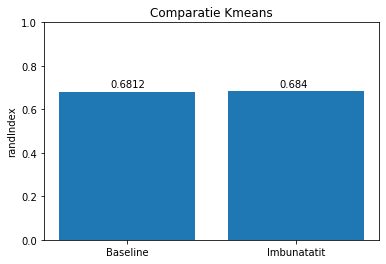

In [22]:
y_pos = np.arange(len(k_means_metrics))
plt.bar(y_pos, k_means_metrics)
plt.xticks(y_pos, ('Baseline', 'Imbunatatit'))
plt.ylim(0, 1)
plt.ylabel('randIndex')
for index, value in enumerate(k_means_metrics):
            plt.text(index - 0.1, value + 0.02, str(round(value, 4)))
plt.title('Comparatie Kmeans')

plt.show()

#### Grafice intra-algoritm

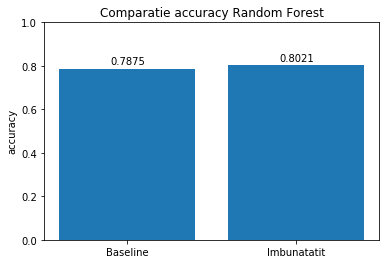

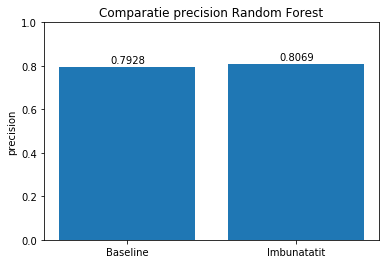

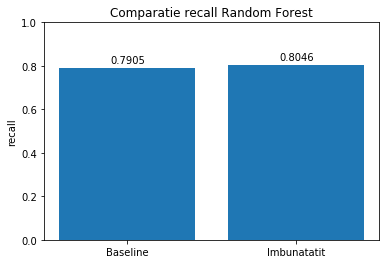

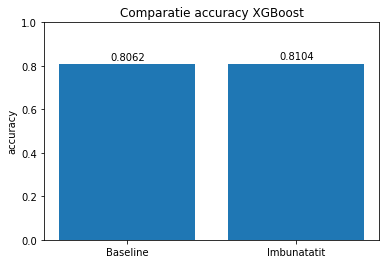

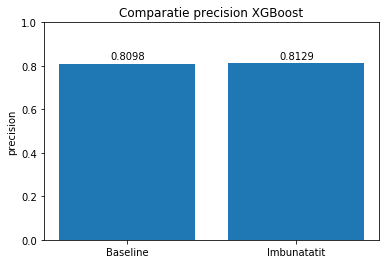

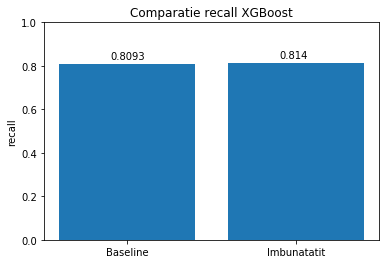

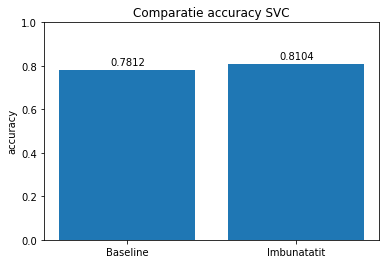

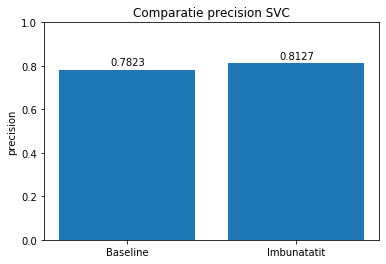

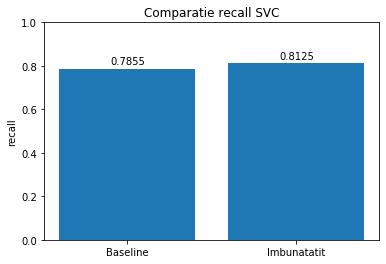

In [23]:
y_pos = np.arange(2)
metrics = ['accuracy', 'precision', 'recall']
names = ['Random Forest', 'XGBoost', 'SVC']

for i in range(len(classifier_metrics)):
    for j in range(len(metrics)):
        if j == 0:
            values = [classifier_metrics[i][0][metrics[j]], classifier_metrics[i][1][metrics[j]]]
        else:
            values = [mean(classifier_metrics[i][0][metrics[j]]), mean(classifier_metrics[i][1][metrics[j]])]

        plt.bar(y_pos, values)
        plt.xticks(y_pos, ('Baseline', 'Imbunatatit'))
        plt.ylim(0, 1)
        plt.ylabel(metrics[j])
        for index, value in enumerate(values):
            plt.text(index - 0.1, value + 0.02, str(round(value, 4)))
        plt.title('Comparatie ' + metrics[j] + ' ' + names[i])
        plt.show()

#### Grafice inter-algoritm

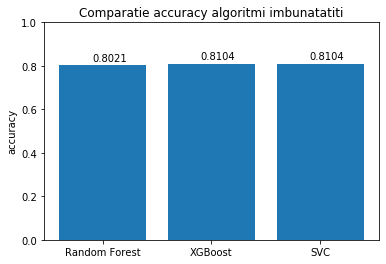

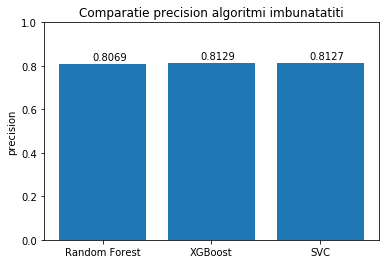

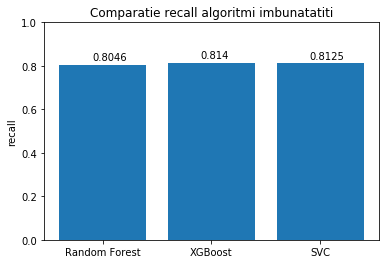

In [24]:
y_pos = np.arange(3)
metrics = ['accuracy', 'precision', 'recall']
names = ['Random Forest', 'XGBoost', 'SVC']

for i in range(len(metrics)):
    if i == 0:
        values = [classifier_metric[1][metrics[i]] for classifier_metric in classifier_metrics]
    else:
        values = [mean(classifier_metric[1][metrics[i]]) for classifier_metric in classifier_metrics]

    plt.bar(y_pos, values)
    plt.xticks(y_pos, names)
    plt.ylim(0, 1)
    plt.ylabel(metrics[i])
    for index, value in enumerate(values):
        plt.text(index - 0.1, value + 0.02, str(round(value, 4)))
    plt.title('Comparatie ' + metrics[i] + ' algoritmi imbunatatiti')
    plt.show()

#### Concluzii

In ceea ce priveste KMeans nu observam diferente majore, deoarece problema este una de clasificare si nu de clusterizare. Se observa o mica diferenta intre rezultatul pe datele initiale si cel pe datele standardizate si inca o mica diferenta intre varianta baseline si varianta optimizata. Nu am gasit vreun parametru mai relevant decat numarul maxim de iteratii si toleranta, dar acestea nu influenteaza prea mult rezultatul.

Random Forest este cel mai rapid, dar are performantele cele mai slabe. Hiperparametri considerati au fost numarul de estimatori, pentru a aveam mai multi estimatori care sa voteze, adancimea maxima a arborilor si numarul maxim de featururi considerate pentru un arbore.

XGBoost are performantele cele mai bune, dar merge si cel mai greu dintre toti. De asemenea, nu este foarte sensibil la modificarea hiperparametrilor, imbunatatirea nefiind foarte mare. Hiperparametri considerati sunt numarul de estimatori, adancimea maxima a unui arbore, tipul de model de baza si rata de invatare.

SVC are performate asemanatoare cu XGBoost si ruleaza mai repede. De asemenea, se obtine o diferenta destul de mare intre varianta baseline si varianta imbunatatita, ceea ce inseamna ca poate putem obtine rezultate si mai bune alegand un C mai fin.

## 5. Mențiuni

"Rezolvarea" unei probleme de învățare automată se reduce la îmbunătățirea unei metrici.

Un prim pas important este reprezentat de crearea unui *baseline* sau a unei soluții banale, de start (eng. *vanilla solution*) și măsurarea acesteia.

Următorul pas îl reprezintă o serie de modificări aduse feature setului sau algoritmului de învățăre. Aceast pas reprezintă o iterație peste soluția inițială.

Tot procesul constă în aplicarea mai multor *iterații* până se ajunge la o valoare a metricii suficient de bună pentru problema de rezolvat. În cazul nostru, această valoare este reprezentată de ambiția fiecăruia dintre voi :)

**Recomandări**:
* biblioteca [sklearn](https://scikit-learn.org/) - oferă o colecție algoritmi de învățare automată, metrici, metode de selectare de caractaristici, etc.
* pentru XGBoost puteți folosit biblioteca [xgboost](https://xgboost.readthedocs.io/en/latest/)

## 6. Sample test
Biblioteca [librosa](https://librosa.github.io/librosa/) permite analizarea și redarea sunetelor.

Se poate folosi pentru a observa dacă anumite melodii găsite într-un anumit gen muzical sunt asemănătoare.

In [ ]:
track_test = tracks[test].sample(1)
title = track_test[('track', 'title')].values[0]
genre = track_test[('track', 'genre_top')].values[0]
print(f"Song\n\ttitle: {title}\n\tgenre {genre}")

song_path = get_song_path(track_test.index.values[0])
song, rate = librosa.load(song_path)
ipd.Audio(song, rate=rate)

## 7. Link-uri utile
* [Evaluarea algoritmilor de clusterizare](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html)
* [Standardizare vs Normalizare](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

## Bibliografie
<a name="fma">[1] *Michaël Defferrard, Kirell Benzi, Pierre Vandergheynst, Xavier Bresson, FMA: A Dataset For Music Analysis, 18th International Society for Music Information Retrieval Conference, 2017*</a>

